In [2]:
import sys
sys.path.append("..")
from sif_src.loader import load_data, save_processed_data
from sif_src.preprocess_data import preprocess_text
from sif_src.utils import load_glove, load_glove_vectors
from sif_src.sif import compute_word_frequencies, compute_sif_weights, compute_sif_embeddings, remove_pc
from pathlib import Path
import pandas as pd
import numpy as np
import pickle

[nltk_data] Downloading package punkt to /Users/yegor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yegor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
"""train_df = pd.read_pickle("../pickle_backups/0607_train_glove.pickle")
valid_df = pd.read_pickle("../pickle_backups/0607_valid_glove.pickle")"""

In [3]:
train_df = pd.read_pickle("../pickle_backups/0607_train_sifglove.pickle")
valid_df = pd.read_pickle("../pickle_backups/0607_valid_sifglove.pickle")

In [4]:
train_df

,query,query_id,passage_text,query_glove,passage_glove,query_sif,passage_sif
0,what is rba,19699,"Since 2007, the RBA's outstanding reputation h...","[0.17393333713213602, -0.024219670643409092, -...","[0.2451033314768086, 0.11505866904991754, -0.0...","[-0.5499034188567763, -0.7749831479943364, -0....","[0.00427330298256676, -0.00928837591945891, -0..."
1,was ronald reagan a democrat,19700,"In his younger years, Ronald Reagan was a memb...","[-0.2430683970451355, 0.24003800451755525, 0.2...","[0.06672714068506992, 0.11755109402308657, -0....","[-0.4944479514982799, 0.3329798641881142, 0.65...","[-0.012322970349242719, -0.002421388997981353,..."
2,how long do you need for sydney and surroundin...,19701,"Sydney, New South Wales, Australia is located ...","[0.3590648201527074, 0.3001724988222122, -0.08...","[0.2715064761884215, 0.18062173768958312, -0.0...","[-0.568552535976231, 0.7885167135846756, -0.70...","[0.0031341151968833267, -0.009394685517612297,..."
3,price to install tile in shower,19702,"In regards to tile installation costs, consume...","[0.3093609996140003, 0.11179117175439994, 0.39...","[0.21163139129547695, 0.2461279927964964, 0.16...","[0.3371495406274633, 0.29204465099172233, 0.29...","[-0.0014441721377124348, 0.008340267834167978,..."
4,why conversion observed in body,19703,"Conclusions: In adult body CT, dose to an orga...","[0.42426599860191344, 0.0575822040438652, -0.2...","[0.3912349340703596, 0.12223484068918411, -0.1...","[0.4894170324722726, 0.02990451910280419, -0.2...","[0.0048614652860068976, -0.008018337339299639,..."
...,...,...,...,...,...,...,...
891052,nasa credit union routing number,462353,Complete a Direct Dispute Form if you have inf...,"[0.3137059897184372, 0.2028579980134964, 0.708...","[0.22793951545742602, 0.12387145513009737, 0.1...","[1.5453032553906523, 0.5568772979426727, 1.329...","[0.0004909238534146562, -0.0001098253777369172..."
891053,what county is hitchcock texas located in,607295,Most of the city of Hitchcock is served by the...,"[0.07771856231348855, 0.3966410058949675, -0.3...","[0.18778673215966785, 0.16093779158439825, -0....","[0.1788231800033896, 0.2960515648697522, -0.59...","[-0.0003284305213075634, 0.0001740455222266607..."
891054,what is blowout for hair,724819,"And with no waiting period, the treatment is f...","[0.2347540020942688, 0.1842821903526783, -0.16...","[0.17134764477241435, 0.16056762918242215, -0....","[0.4115628552745297, -0.6612440273198792, 0.97...","[0.0003564168341267576, -0.0010824518326012127..."
891055,what car does isaac bell drive in the wrecker,583161,Isaac Bell is the son of Ebenezer Bell and gra...,"[0.08927911147475243, 0.06939421966671944, 0.2...","[0.1807504956500967, 0.10896012842600128, -0.0...","[-0.6717474092433464, -0.37378372149169947, 0....","[-0.002426316277516103, -0.015871782547841135,..."


In [12]:
"""glove_vectors = load_glove_vectors('../wv/glove.6B.50d.txt')"""

Loading GloVe Vectors: 100%|██████████| 400000/400000 [00:29<00:00, 13458.40it/s]


In [11]:
"""from collections import Counter

word_counts = Counter()
for sentence in train_df['query'].tolist() + train_df['passage_text'].tolist():
    word_counts.update(sentence.split())
"""

In [15]:
"""import math

def sif_weight(word, a=1e-3):
    return a / (a + word_counts[word])

def sentence_to_sif(sentence, embeddings_index, embedding_dim=50, a=1e-3):
    words = sentence.split()
    weights = [sif_weight(word) for word in words]
    embedding_matrix = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector * weights[i]
    return np.sum(embedding_matrix, axis=0) / (np.sum(weights) + 1e-9)

train_df['query_sif'] = train_df['query'].apply(lambda x: sentence_to_sif(x, glove_vectors))
train_df['passage_sif'] = train_df['passage_text'].apply(lambda x: sentence_to_sif(x, glove_vectors))"""

In [16]:
"""valid_df['query_sif'] = valid_df['query'].apply(lambda x: sentence_to_sif(x, glove_vectors))
valid_df['passage_sif'] = valid_df['passage_text'].apply(lambda x: sentence_to_sif(x, glove_vectors))"""

In [17]:
"""with open('../pickle_backups/0607_valid_sifglove.pickle', 'wb') as f:
    pickle.dump(valid_df, f)"""

In [18]:
"""with open('../pickle_backups/0607_train_sifglove.pickle', 'wb') as f:
    pickle.dump(train_df, f)"""

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_and_evaluate_model(X_train, y_train, X_valid, y_valid):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return accuracy_score(y_valid, y_pred)


In [6]:
X_train_glove = np.concatenate([train_df['query_glove'].tolist(), train_df['passage_glove'].tolist()], axis=1)
X_valid_glove = np.concatenate([valid_df['query_glove'].tolist(), valid_df['passage_glove'].tolist()], axis=1)

X_train_sif = np.concatenate([train_df['query_sif'].tolist(), train_df['passage_sif'].tolist()], axis=1)
X_valid_sif = np.concatenate([valid_df['query_sif'].tolist(), valid_df['passage_sif'].tolist()], axis=1)

y_train = train_df['label'].values
y_valid = valid_df['label'].values


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between each query and its corresponding passage
cos_sim_train = [cosine_similarity([q], [p])[0][0] for q, p in zip(train_df['query_glove'], train_df['passage_glove'])]
cos_sim_valid = [cosine_similarity([q], [p])[0][0] for q, p in zip(valid_df['query_glove'], valid_df['passage_glove'])]

# Output some statistics
print("Training Cosine Similarity - Mean:", np.mean(cos_sim_train), "Std:", np.std(cos_sim_train))
print("Validation Cosine Similarity - Mean:", np.mean(cos_sim_valid), "Std:", np.std(cos_sim_valid))


Training Cosine Similarity - Mean: 0.8769740931378143 Std: 0.11579811888593364
Validation Cosine Similarity - Mean: 0.8737680990455351 Std: 0.1231798340124543


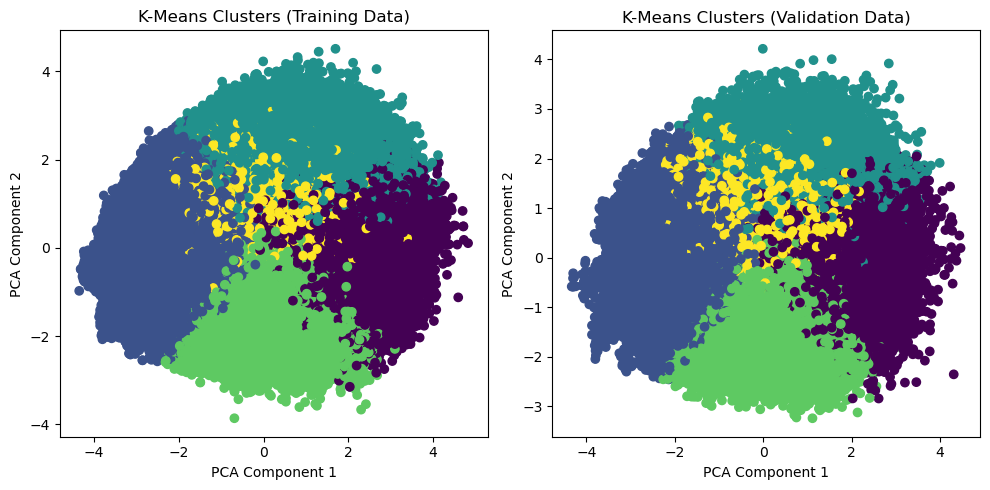

Cluster Centers:
 [[ 2.62045432e-01  9.20098997e-02 -3.24380541e-02 -2.49686920e-02
   2.06882213e-01  2.18010170e-01 -1.11270909e-02 -2.83868848e-01
   6.40361258e-02  1.56267652e-01  1.44501524e-01  1.40530471e-01
  -1.88651522e-03 -6.36758532e-02  2.21910952e-01  2.56670541e-01
   1.34052668e-02  1.01638152e-01  1.09543121e-03 -2.78916822e-01
  -9.98000810e-02 -8.67421511e-02  1.14523565e-01  1.26010405e-01
   1.34401353e-01 -9.50904051e-01 -3.66371178e-01  9.72176038e-02
   2.45953634e-01 -1.58054799e-01  2.16662208e+00 -2.40987949e-02
  -1.78315427e-01 -2.73343000e-01  2.88696283e-02 -4.06129035e-02
   7.34940719e-02  3.64352879e-02  5.69063096e-02 -9.18665434e-02
   1.47395884e-02 -3.68220998e-03 -3.29600612e-02  3.20909515e-01
  -8.55411970e-02  3.75242991e-02  1.42826726e-01  1.01420809e-01
   1.11503247e-02  1.32262650e-01  2.59341894e-01  1.32955929e-01
  -2.30946713e-02 -3.32516204e-02  2.09452593e-01  2.10941035e-01
  -1.77947708e-01 -1.68624756e-01 -6.31702711e-03 -7.25723

In [8]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Combine GLOVE and SIF embeddings
X_train_combined = np.concatenate([X_train_glove, X_train_sif], axis=1)
X_valid_combined = np.concatenate([X_valid_glove, X_valid_sif], axis=1)

# Determine the number of clusters (k)
k = 5  # You can choose a different number of clusters based on your needs

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
train_clusters = kmeans.fit_predict(X_train_combined)
valid_clusters = kmeans.predict(X_valid_combined)

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_combined)
X_valid_pca = pca.transform(X_valid_combined)

plt.figure(figsize=(10, 5))

# Plot training data
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis')
plt.title('K-Means Clusters (Training Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Plot validation data
plt.subplot(1, 2, 2)
plt.scatter(X_valid_pca[:, 0], X_valid_pca[:, 1], c=valid_clusters, cmap='viridis')
plt.title('K-Means Clusters (Validation Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

# Optional: Analyze cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)


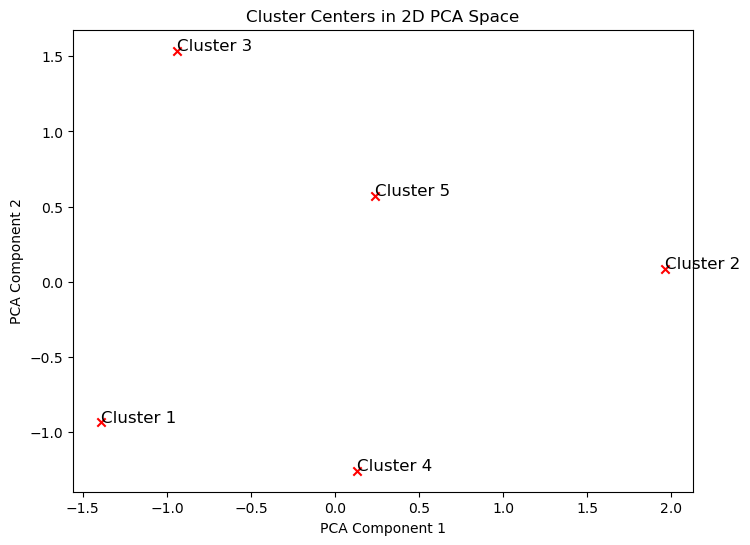

Cluster Centers:
 [[ 2.62045432e-01  9.20098997e-02 -3.24380541e-02 -2.49686920e-02
   2.06882213e-01  2.18010170e-01 -1.11270909e-02 -2.83868848e-01
   6.40361258e-02  1.56267652e-01  1.44501524e-01  1.40530471e-01
  -1.88651522e-03 -6.36758532e-02  2.21910952e-01  2.56670541e-01
   1.34052668e-02  1.01638152e-01  1.09543121e-03 -2.78916822e-01
  -9.98000810e-02 -8.67421511e-02  1.14523565e-01  1.26010405e-01
   1.34401353e-01 -9.50904051e-01 -3.66371178e-01  9.72176038e-02
   2.45953634e-01 -1.58054799e-01  2.16662208e+00 -2.40987949e-02
  -1.78315427e-01 -2.73343000e-01  2.88696283e-02 -4.06129035e-02
   7.34940719e-02  3.64352879e-02  5.69063096e-02 -9.18665434e-02
   1.47395884e-02 -3.68220998e-03 -3.29600612e-02  3.20909515e-01
  -8.55411970e-02  3.75242991e-02  1.42826726e-01  1.01420809e-01
   1.11503247e-02  1.32262650e-01  2.59341894e-01  1.32955929e-01
  -2.30946713e-02 -3.32516204e-02  2.09452593e-01  2.10941035e-01
  -1.77947708e-01 -1.68624756e-01 -6.31702711e-03 -7.25723

In [9]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming cluster_centers is obtained from kmeans.cluster_centers_
cluster_centers = kmeans.cluster_centers_

# Apply PCA to reduce dimensions of cluster centers for visualization
pca = PCA(n_components=2)
cluster_centers_pca = pca.fit_transform(cluster_centers)

# Plot the cluster centers in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], marker='x', color='red')
for i, center in enumerate(cluster_centers_pca):
    plt.text(center[0], center[1], f'Cluster {i+1}', fontsize=12)
plt.title('Cluster Centers in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Print cluster centers for detailed analysis
print("Cluster Centers:\n", cluster_centers)


In [ ]:
accuracy_glove = train_and_evaluate_model(X_train_glove, y_train, X_valid_glove, y_valid)
accuracy_sif = train_and_evaluate_model(X_train_sif, y_train, X_valid_sif, y_valid)

print(f"GloVe Accuracy: {accuracy_glove}")
print(f"SIF Accuracy: {accuracy_sif}")


array([ 0.33714954,  0.29204465,  0.29079326, -0.04622583, -0.25377112,
       -0.27544449,  0.18629604,  0.01818666, -0.32870526,  0.08651173,
       -0.0701531 , -0.12308122,  0.538405  ,  0.87404574,  0.16657964,
        0.70982794, -0.41456536,  0.25851255,  0.11816247, -1.36065652,
        0.38002955, -0.0518354 , -0.48632111, -0.64531349, -0.29150088,
       -0.05555782, -0.52431517,  0.8224517 ,  0.6408944 , -0.32537978,
        1.44571189, -0.11810294, -0.48562866,  0.25820946, -0.25707015,
        1.02779793,  0.9014725 ,  0.47890314,  0.91726603, -0.31391812,
        0.27115333,  0.18626568, -0.10688476,  0.54189839,  0.38980344,
        0.14034387,  0.217777  , -1.0123348 , -0.04874033, -0.36526696])

In [42]:
queries = np.array(train_df["query"].to_list())
passages = np.array(train_df["passage_text"].to_list()) 
query_embeddings_sif = np.array(train_df["query_sif"].to_list())
passage_embeddings_sif = np.array(train_df["passage_sif"].to_list())
query_embeddings_glove = np.array(train_df["query_glove"].to_list())
passage_embeddings_glove = np.array(train_df["passage_glove"].to_list())

: 

In [35]:
#cosine_similarity(query_embeddings_glove[3], query_embeddings_sif[3])



((50,), (50,))

In [40]:
len(queries), len(passages), len(query_embeddings_glove), len(passage_embeddings_glove)

(891057, 891057, 891057, 891057)

In [39]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

# Semantic search function
def semantic_search(queries, passages, query_embeddings, passage_embeddings):
    search_results = {}
    for i, query in enumerate(queries):
        similarities = cosine_similarity([query_embeddings[i]], passage_embeddings)[0]
        ranked_indices = np.argsort(similarities)[::-1]
        search_results[query] = [passages[idx] for idx in ranked_indices]
    return search_results

# Evaluation function
def evaluate_search_results(search_results, ground_truth_answers):
    mrr = np.mean([1.0 / (search_results[query].index(ground_truth_answers[query]) + 1) for query in ground_truth_answers])
    ndcg = np.mean([ndcg_score([ground_truth_answers[query]], [[search_results[query].index(ground_truth_answers[query]) + 1]]) for query in ground_truth_answers])
    return mrr, ndcg

#ground_truth_answers = {"query1": "answer1", "query2": "answer2", ...}  # Load ground truth answers

# Perform semantic search using SIF embeddings
search_results_sif = semantic_search(queries, passages, query_embeddings_sif, passage_embeddings_sif)

# Perform semantic search using GloVe embeddings
search_results_glove = semantic_search(queries, passages, query_embeddings_glove, passage_embeddings_glove)

# Evaluate results
#mrr_sif, ndcg_sif = evaluate_search_results(search_results_sif, ground_truth_answers)
#mrr_glove, ndcg_glove = evaluate_search_results(search_results_glove, ground_truth_answers)

#print("SIF Embeddings - MRR:", mrr_sif)
#print("SIF Embeddings - NDCG:", ndcg_sif)
#print("GloVe Embeddings - MRR:", mrr_glove)
#print("GloVe Embeddings - NDCG:", ndcg_glove)


ValueError: setting an array element with a sequence.

In [ ]:
"""def predict(params, inputs):
    return np.dot(inputs, params)

def loss_fn(params, inputs, targets):
    predictions = predict(params, inputs)
    return np.mean((predictions - targets) ** 2)

def update(params, inputs, targets, learning_rate=0.01):
    grads = grad(loss_fn)(params, inputs, targets)
    return params - learning_rate * grads

# Train the model
def train_model(X_train, y_train, num_epochs=100, learning_rate=0.01):
    params = np.zeros(X_train.shape[1])
    for epoch in range(num_epochs):
        params = update(params, X_train, y_train, learning_rate)
    return params"""

In [ ]:
"""params_sif = train_model(X_train_sif, y_train)"""

In [ ]:
"""def evaluate_model(params, X_valid, y_valid):
    predictions = predict(params, X_valid)
    return np.mean((predictions - y_valid) ** 2)"""

In [ ]:
"""mse_sif = evaluate_model(params_sif, X_valid_sif, y_valid)
print(f"SIF MSE: {mse_sif}")"""